## 1. Импорт библиотек

Импортируем стандартные библиотеки для анализа данных, а также пользовательские функции для визуализации и первичного осмотра данных.

In [2]:
import os

import pandas as pd
import numpy as np

from utils.overview import describe_categorical
from utils.vizualization import plot_hist_boxplot, plot_categorial_pie, plot_topn_bar
from utils.correlation import get_eta_correlation

## 2. Установка рабочей директории

Определяем корневую директорию проекта для корректного чтения файлов.

In [3]:
HOME = os.getcwd().removesuffix("/notebooks")

## 3. Загрузка очищенных данных

Загружаем файлы cleaned_rides.csv и cleaned_weather.csv нормализованные после очитски.

In [4]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": f"{HOME}/data/cleaned_rides.csv",
    "encoding": "utf-8",
    "parse_dates": ["start_date", "end_date"],
}

weather_options = {
    "filepath_or_buffer": f"{HOME}/data/cleaned_weather.csv",
    "encoding": "utf-8",
    "parse_dates": ["datetime"]
}

rides_data = pd.read_csv(**rides_options)
weather_data = pd.read_csv(**weather_options)

## 4. Обзор данных о поездках

После загрузки очищенного датасета выполняется осмотр структуры таблицы, типов данных и распределений основных признаков.


С помощью .head() и .info() проверяем корректность типов столбцов, отсутствие ошибок при чтении дат и соответствие структуры ожидаемому формату. Метод .shape используем для вывода количества оставшихся строк и столбцов после предварительной обработки.

In [5]:
rides_data.head()

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,duration_minutes,total_price,speed_km_per_h
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,суббота,шевченко,юго-восточный,майская,октябрьский,4069.0,Нет,24.0,126.0,10.172500
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,суббота,чехова,заречный,спортивная,октябрьский,4515.0,Нет,28.0,142.0,9.675000
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,суббота,буденного,октябрьский,суворова,ленинский,4520.0,Нет,38.0,182.0,7.136842
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,суббота,труда,центральный,рабочая,северо-западный,3881.0,Нет,32.0,158.0,7.276875
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,суббота,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,Нет,31.0,154.0,7.798065


In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93286 entries, 0 to 93285
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                93286 non-null  int64         
 1   start_date        93286 non-null  datetime64[ns]
 2   end_date          93286 non-null  datetime64[ns]
 3   day_of_week       93286 non-null  object        
 4   start_location    93286 non-null  object        
 5   start_district    93286 non-null  object        
 6   end_location      93286 non-null  object        
 7   end_district      93286 non-null  object        
 8   distance          93286 non-null  float64       
 9   promo             93286 non-null  object        
 10  duration_minutes  93286 non-null  float64       
 11  total_price       93286 non-null  float64       
 12  speed_km_per_h    93286 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(6)
memory usage: 9.3+ MB


In [8]:
rows, cols = rides_data.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  93286
Number of columns:  13


### 4.3. Анализ числовых признаков

Выделяем числовые столбцы (кроме id) и выводим таблицу описательной статистики: средние значения, стандартное отклонение, диапазон.

Дополнительно визуализируем распределения с помощью plot_hist_boxplot, сравнивая их по признаку promo и оценивая наличие скошенности или аномалий.

In [9]:
rides_num = rides_data.select_dtypes(exclude=["object", "datetime"]).columns.tolist()
rides_num.remove("id")

In [10]:
rides_data[rides_num].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,93286.0,3819.690270,1015.132824,519.00000,3115.000000,3734.0000,4436.000000,8548.000000
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


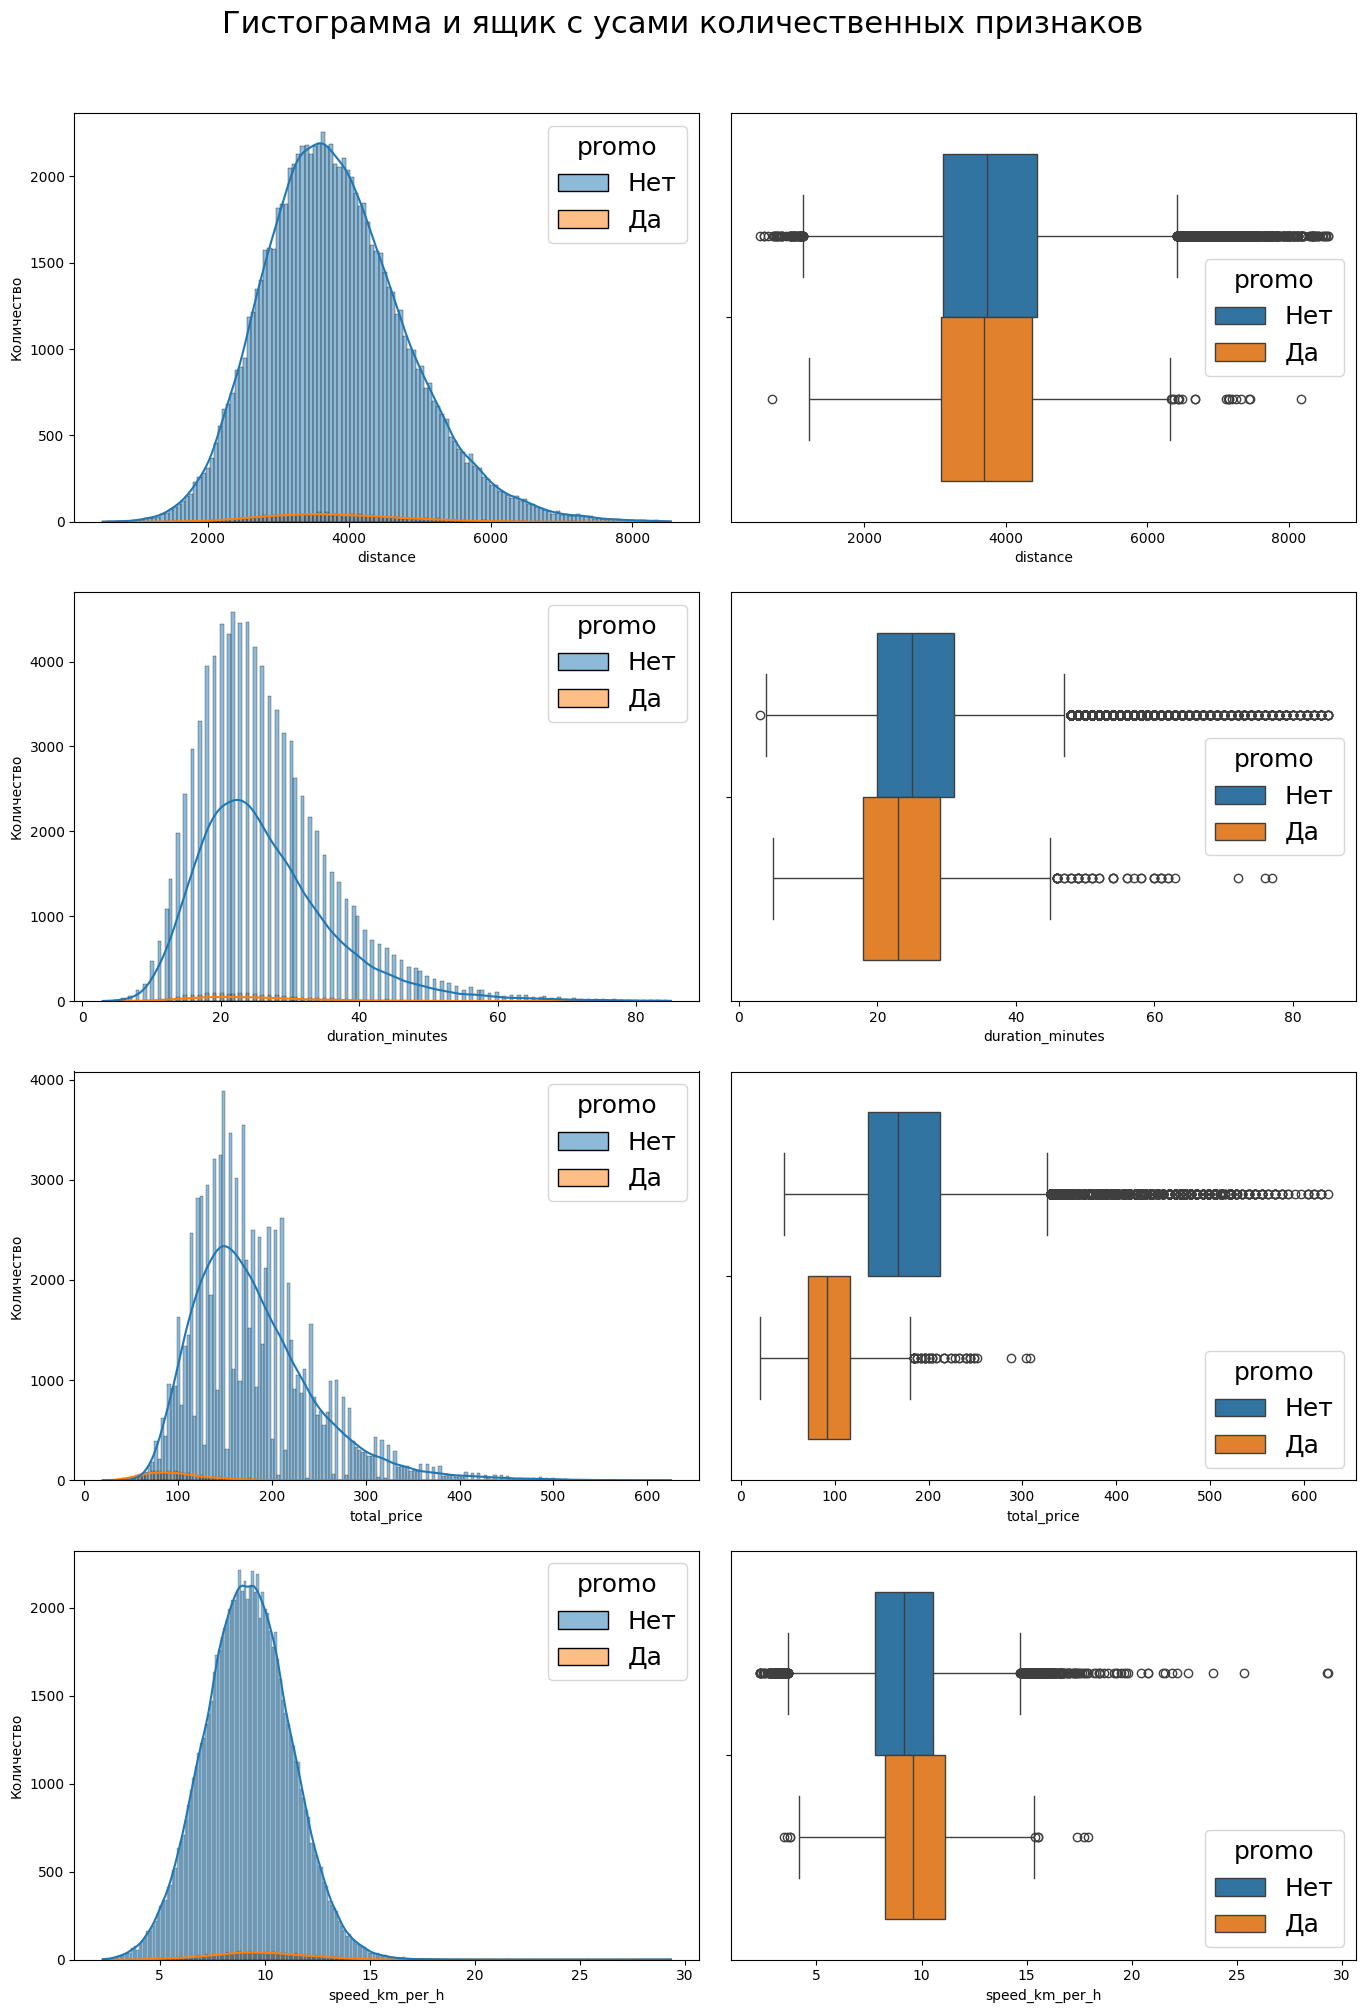

In [11]:
plot_hist_boxplot(rides_data, rides_num, hue="promo", kde=True)

### 4.2. Анализ категориальных признаков

Используем функцию describe_categorical для оценки частот категорий и выводим таблицу описательной статистики.

Строим:
* круговые диаграммы для основных категориальных признаков (день недели, район начала, район окончания);
* бар-чарты для наиболее популярных стартовых и конечных локаций.


In [7]:
describe_categorical(rides_data)

Column: day_of_week
- Unique values: 7
- Top 30 most frequent values:
day_of_week
воскресенье    17394
суббота        17222
пятница        13526
понедельник    12200
среда          11177
четверг        11045
вторник        10722
Name: count, dtype: int64

Column: start_location
- Unique values: 91
- Top 30 most frequent values:
start_location
ломоносова       2202
луговая          2195
майская          2152
буденного        2101
восточная        2094
спортивная       2094
пионерская       1613
шоссейная        1502
комсомольская    1499
садовая          1471
октябрьская      1440
чехова           1421
школьная         1198
чапаева          1183
березовая        1178
строительная     1174
новая            1171
красная          1149
рабочая          1141
некрасова        1135
цветочная        1117
первомайская     1112
московская       1109
лермонтова       1104
суворова         1093
рябиновая        1089
подгорная        1088
колхозная        1087
партизанская     1083
комарова         

In [12]:
rides_cat = rides_data.select_dtypes(include="object").columns

In [13]:
rides_data[rides_cat].describe().T

,count,unique,top,freq
day_of_week,93286,7,воскресенье,17394
start_location,93286,91,ломоносова,2202
start_district,93286,6,центральный,24005
end_location,93286,91,спортивная,2221
end_district,93286,6,центральный,23458
promo,93286,2,Нет,91455


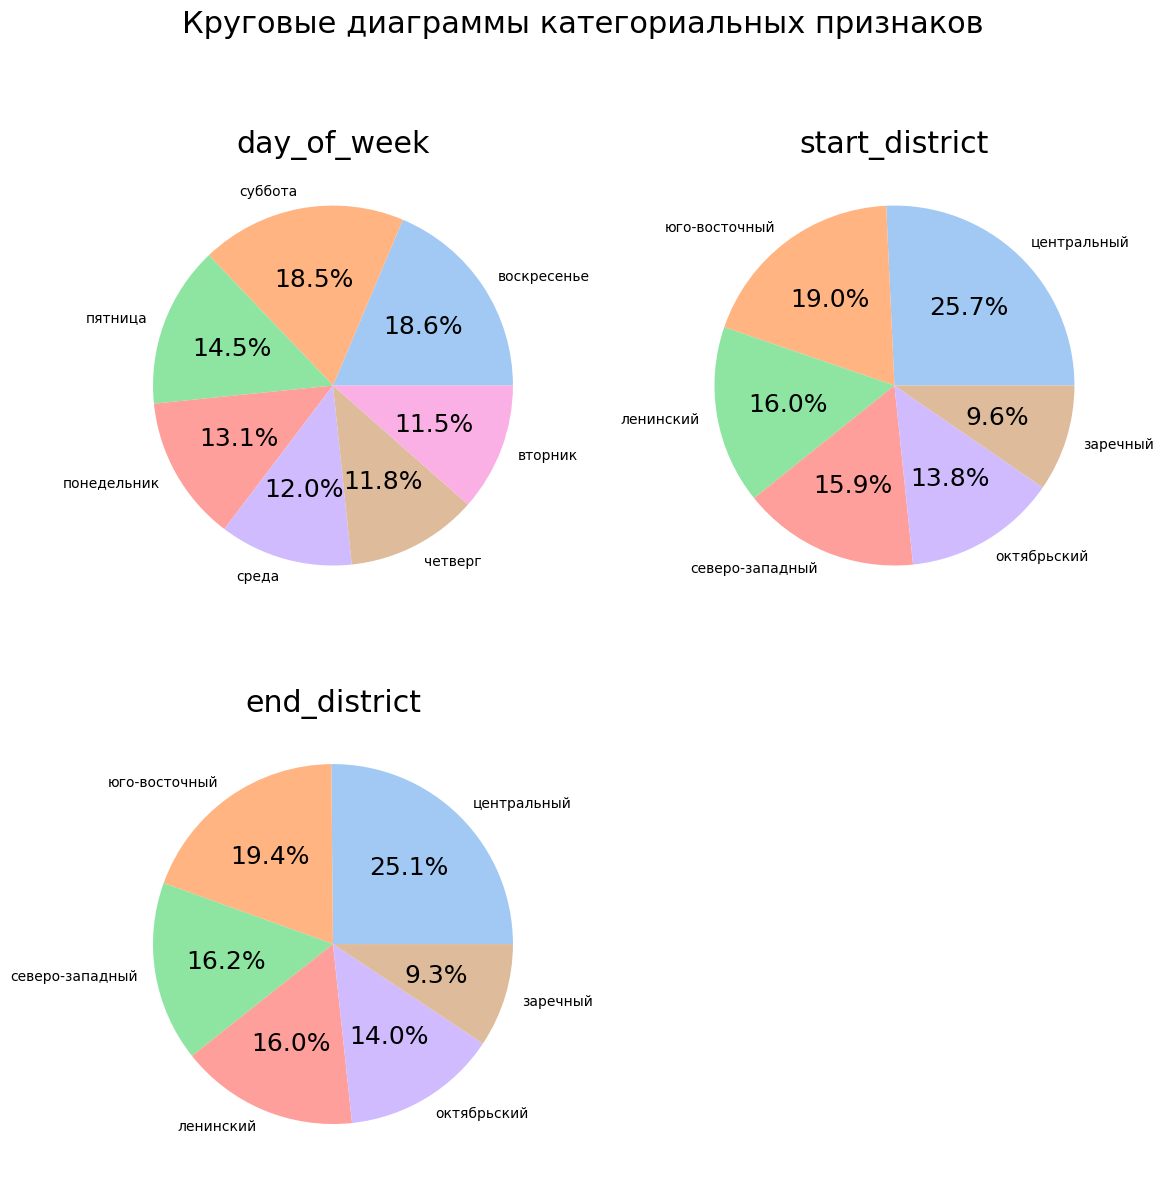

In [14]:
plot_categorial_pie(rides_data, ["day_of_week", "start_district", "end_district"], 2)

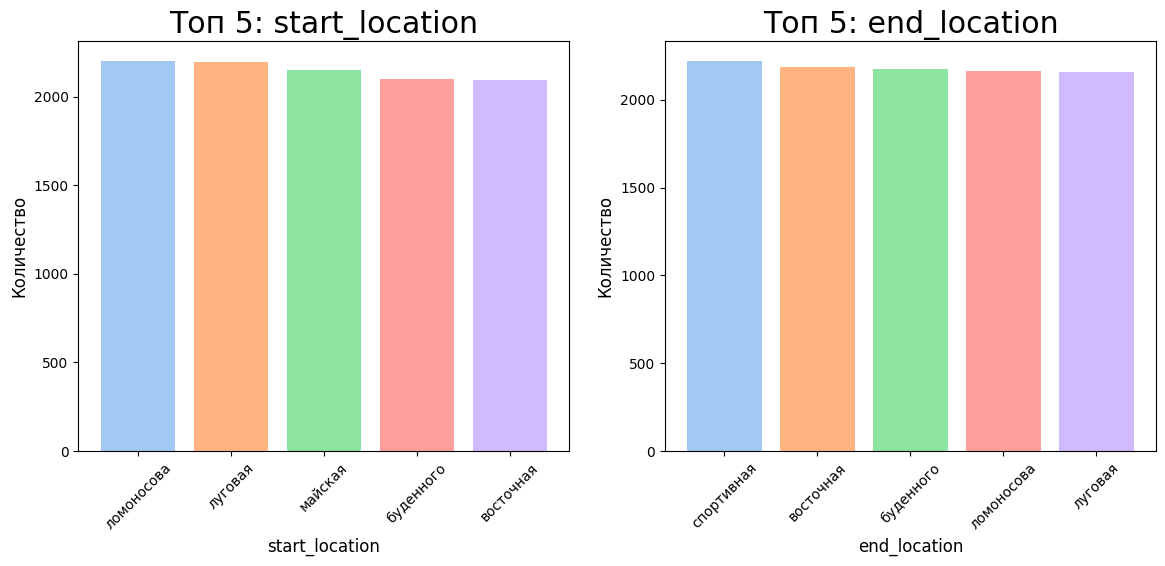

In [15]:
plot_topn_bar(rides_data, ["start_location", "end_location"], n=5)

### 4.4. Корреляция категориальных и числовых признаков

Для проверки взаимосвязи между day_of_week и total_price применяем коэффициент корреляции `eta`.


In [16]:
get_eta_correlation(rides_data["day_of_week"], rides_data["total_price"])

np.float64(0.283)

## 5. Исследование спроса в понедельник утром

### 5.1. Фильтрация данных

Выбираем поездки, совершённые:
* в понедельник (day_of_week == "понедельник")
* в утренние часы (с 06:00 до 10:00)

Этот временной интервал важен для оценки commuter-поведения и эффективности утренних промо-кампаний.

In [17]:
monday_morning = rides_data[
    (rides_data['day_of_week'] == 'понедельник') &
    (rides_data["start_date"].dt.hour >= 6) &
    (rides_data["start_date"].dt.hour < 10)
]

### 5.2. Статистика поездок

Считаем:
* количество поездок с/без промо,
* среднюю стоимость,
* суммарную выручку.

Это позволяет увидеть разницу в спросе между акционными и обычными поездками.

In [18]:
count_by_promo = monday_morning.groupby('promo')['id'].count()
avg_price_by_promo = monday_morning.groupby('promo')['total_price'].mean()
total_revenue_by_promo = monday_morning.groupby('promo')['total_price'].sum()

print("Количество поездок в понедельник утром:")
print(count_by_promo)
print("\nВыручка с поездок:")
print(total_revenue_by_promo)
print("\nСредняя стоимость поездки:")
print(avg_price_by_promo)

Количество поездок в понедельник утром:
promo
Да     1831
Нет     734
Name: id, dtype: int64

Выручка с поездок:
promo
Да     180948.0
Нет     95052.0
Name: total_price, dtype: float64

Средняя стоимость поездки:
promo
Да      98.824686
Нет    129.498638
Name: total_price, dtype: float64


### 5.3. Эффективность промо-акции

Считаем:
* долю поездок, совершённых с промокодом,
* выручку от поездок с промо,
* издержки компании (30 ₽ за каждую поездку),
* итоговую окупаемость акции.

Этот блок даёт оценку рентабельности утреннего промо и помогает принимать решения о повторении подобных акций.

In [19]:
# Отбираем поездки с промо в понедельник утром
promo_rides = monday_morning[monday_morning["promo"] == "Да"]

# Конверсия поездок с промо
promo_share = promo_rides.shape[0] / monday_morning.shape[0]
print(f"Конверсия поездок с промо: {promo_share:.1%}\n")

# Выручка и издержки
revenue_promo = promo_rides["total_price"].sum()
promo_cost = promo_rides.shape[0] * 30  # 30 руб. за поездку

print(f"Выручка с промо: {revenue_promo:_.0f} руб.")
print(f"Издержки на акцию: {promo_cost:_.0f} руб.")

# Оценка окупаемости
if revenue_promo > promo_cost:
    print("Акция окупилась")
else:
    print("Акция принесла убытки")

Конверсия поездок с промо: 71.4%

Выручка с промо: 180_948 руб.
Издержки на акцию: 54_930 руб.
Акция окупилась
